In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [31]:
data = [
    ['Januari', 1, 2020, 381, 16],
    ['Februari', 2, 2020, 558, 23],
    ['Maret', 3, 2020, 345, 14],
    ['April', 4, 2020, 150, 13],
    ['Mei', 5, 2020, 81, 7],
    ['Juni', 6, 2020, 137, 4],
    ['Juli', 7, 2020, 25, 3],
    ['Agustus', 8, 2020, 17, 1],
    ['September', 9, 2020, 22, 3],
    ['Oktober', 10, 2020, 136, 11],
    ['November', 11, 2020, 204, 14],
    ['Desember', 12, 2020, 387, 21],
    ['Januari', 1, 2021, 840, 30],
    ['Februari', 2, 2021, 397, 20],
    ['Maret', 3, 2021, 626, 23],
    ['April', 4, 2021, 294, 11],
    ['Mei', 5, 2021, 78, 11],
    ['Juni', 6, 2021, 87, 14],
    ['Juli', 7, 2021, 77, 9],
    ['Agustus', 8, 2021, 104, 8],
    ['September', 9, 2021, 83, 11],
    ['Oktober', 10, 2021, 245, 17],
    ['November', 11, 2021, 542, 26],
    ['Desember', 12, 2021, 860, 28],
    ['Januari', 1, 2022, 840, 30],
    ['Februari', 2, 2022, 397, 20],
    ['Maret', 3, 2022, 626, 23],
    ['April', 4, 2022, 294, 11],
    ['Mei', 5, 2022, 78, 11],
    ['Juni', 6, 2022, 87, 14],
    ['Juli', 7, 2022, 77, 9],
    ['Agustus', 8, 2022, 104, 8],
    ['September', 9, 2022, 83, 11],
    ['Oktober', 10, 2022, 245, 17],
    ['November', 11, 2022, 542, 26],
    ['Desember', 12, 2022, 860, 28],
]
df = pd.DataFrame(data, columns=['Bulan', 'Bulan_Num', 'Tahun', 'Curah_Hujan', 'Hari_Hujan'])

In [32]:
def klasifikasi(hari):
    if hari <= 10: return 'Rendah'
    elif hari <= 20: return 'Sedang'
    else: return 'Tinggi'
df['Label'] = df['Hari_Hujan'].apply(klasifikasi)

In [33]:
df['Kuartal'] = df['Bulan_Num'].apply(lambda x: (x-1)//3 + 1)
df['Curah_per_Hari'] = df['Curah_Hujan'] / df['Hari_Hujan']
df['sin_bulan'] = np.sin(2 * np.pi * df['Bulan_Num'] / 12)
df['cos_bulan'] = np.cos(2 * np.pi * df['Bulan_Num'] / 12)

def musim(b):
    if b in [12, 1, 2]: return 'Hujan'
    elif b in [3, 4, 5]: return 'Peralihan1'
    elif b in [6, 7, 8]: return 'Kemarau'
    else: return 'Peralihan2'
df['Musim'] = df['Bulan_Num'].apply(musim)
df = pd.get_dummies(df, columns=['Musim'])

In [34]:
X = df[['Curah_Hujan', 'Hari_Hujan', 'Curah_per_Hari', 'Bulan_Num', 'Tahun', 'Kuartal', 'sin_bulan', 'cos_bulan'] + [col for col in df.columns if col.startswith('Musim_')]]
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)


In [35]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
}
rf = RandomForestClassifier(random_state=42)
grid = GridSearchCV(rf, param_grid, cv=5)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

Best Parameters: {'max_depth': 5, 'n_estimators': 200}
Akurasi: 1.0
              precision    recall  f1-score   support

      Rendah       1.00      1.00      1.00         2
      Sedang       1.00      1.00      1.00         4
      Tinggi       1.00      1.00      1.00         3

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9

Cross-Validation Akurasi:  0.9464285714285715
Semua Fold: [0.875      0.85714286 1.         1.         1.        ]


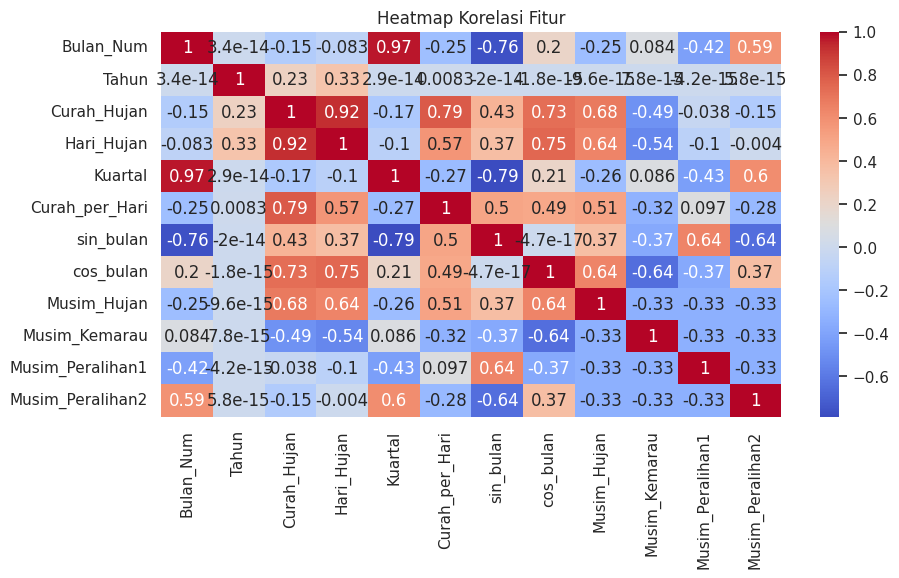

In [36]:
print("Best Parameters:", grid.best_params_)
print("Akurasi:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X, y, cv=cv)
print("Cross-Validation Akurasi: ", cv_scores.mean())
print("Semua Fold:", cv_scores)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Heatmap Korelasi Fitur")
plt.show()

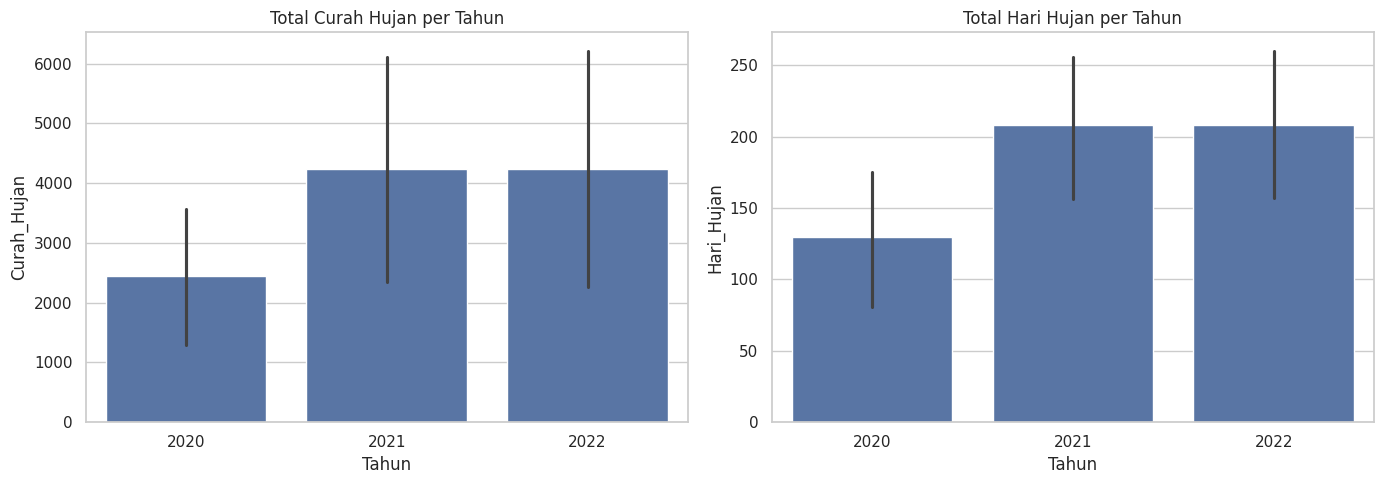

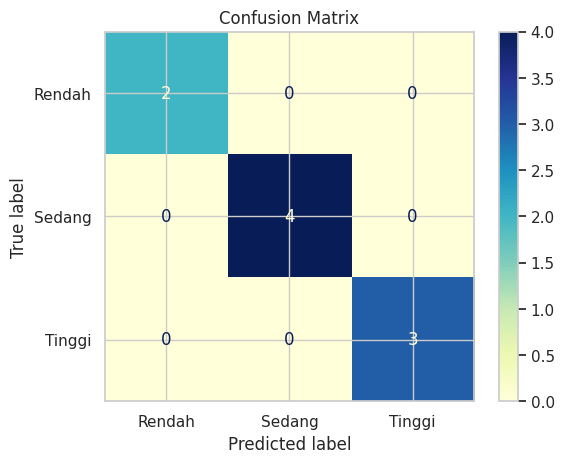

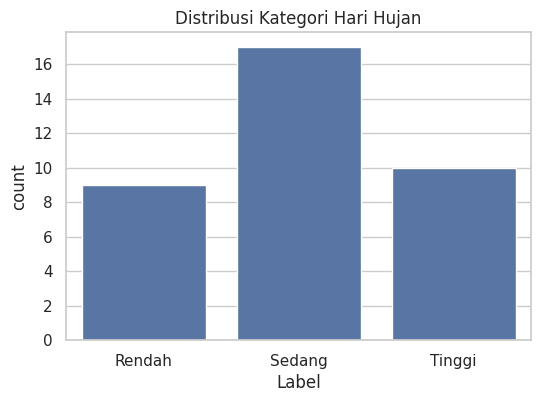

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(data=df, x='Tahun', y='Curah_Hujan', estimator=sum, ax=ax[0])
ax[0].set_title("Total Curah Hujan per Tahun")
sns.barplot(data=df, x='Tahun', y='Hari_Hujan', estimator=sum, ax=ax[1])
ax[1].set_title("Total Hari Hujan per Tahun")
plt.tight_layout()
plt.show()


cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap="YlGnBu")
plt.title("Confusion Matrix")
plt.show()


plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Label', order=['Rendah', 'Sedang', 'Tinggi'])
plt.title("Distribusi Kategori Hari Hujan")
plt.show()


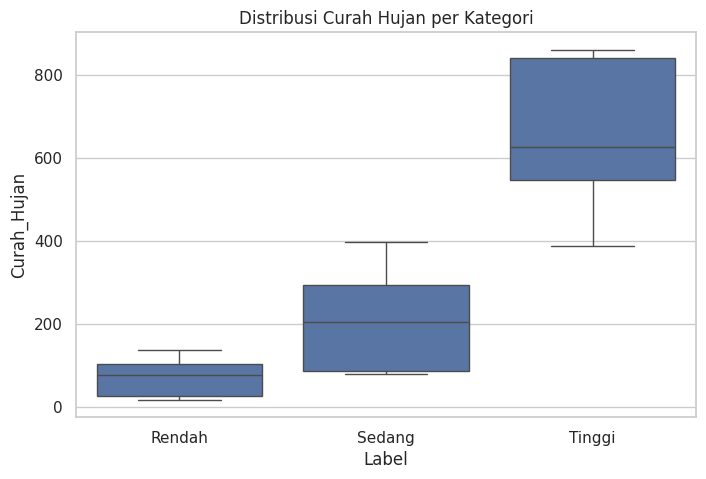

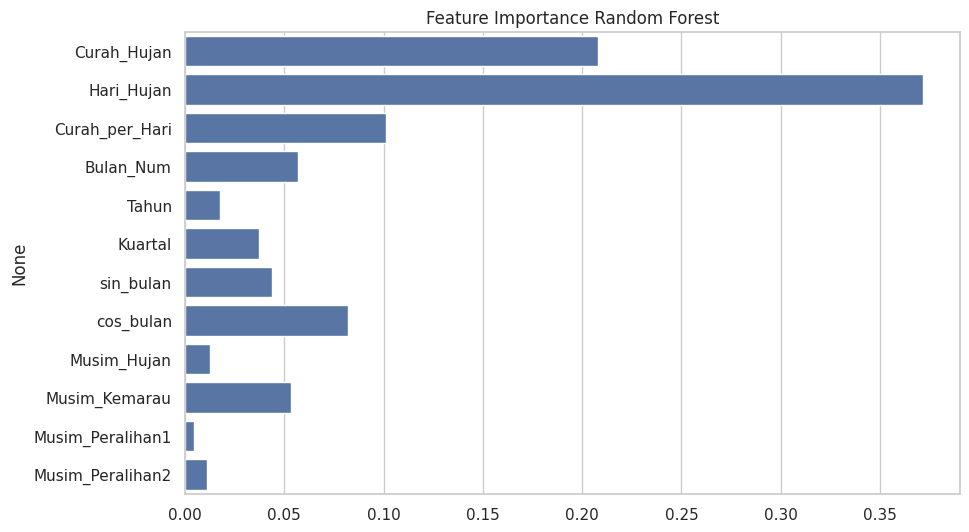

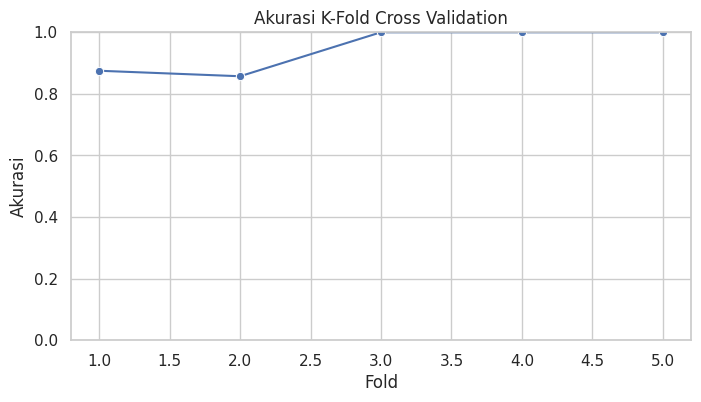

In [38]:




plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='Label', y='Curah_Hujan', order=['Rendah', 'Sedang', 'Tinggi'])
plt.title("Distribusi Curah Hujan per Kategori")
plt.show()


plt.figure(figsize=(10, 6))
sns.barplot(x=best_model.feature_importances_, y=X.columns)
plt.title("Feature Importance Random Forest")
plt.show()


plt.figure(figsize=(8,4))
sns.lineplot(x=range(1, 6), y=cv_scores, marker='o')
plt.ylim(0, 1)
plt.title("Akurasi K-Fold Cross Validation")
plt.xlabel("Fold")
plt.ylabel("Akurasi")
plt.grid(True)
plt.show()
